In [37]:
import math
import random
import numpy as np
from collections import deque
import time

import gymnasium as gym
from gymnasium.wrappers import FrameStack

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [38]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
frames_stacked = 4
env = FrameStack(gym.make("ALE/DonkeyKong-v5"), frames_stacked)

num_actions = env.action_space.n
frame_shape = env.observation_space.shape 

In [40]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_outputs = num_outputs
    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_output_len = int(np.prod(self.conv_layers(torch.zeros(1, *input_shape)).size()))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_len, 120),
            nn.ReLU()
            nn.Linear(120, self.num_outputs)
        )
    
    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        return self.fc_layers(conv_out)

In [41]:
def preprocess(frame):
    processed = np.mean(frame,3, np.float32, keepdims = False, )
    cropped = processed[:,36:195]
    result = cropped[:,::2,::2]
    return torch.from_numpy(result)

state = env.reset()[0] 

input_shape = preprocess(state).shape

input_shape

torch.Size([4, 80, 80])

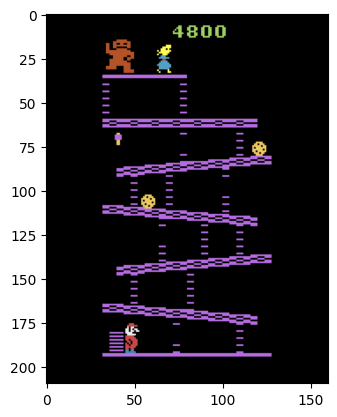

In [42]:
for _ in range(500): state, *_ = env.step(1)
plt.imshow(state[0])

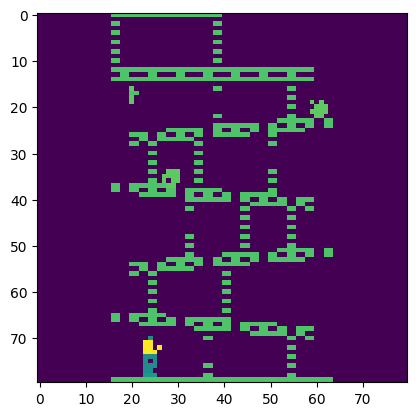

In [43]:
plt.imshow(preprocess(state)[0])

In [44]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)
'''
# Create policy and target network.
policy_net = DQN(input_shape=input_shape, num_outputs=num_actions)
target_net = DQN(input_shape=input_shape, num_outputs=num_actions)

target_net.load_state_dict(policy_net.state_dict())

'''

model(preprocess(state).unsqueeze(0))

tensor([[ 0.1730,  0.5120, -0.6163, -0.8420,  0.3911,  0.8026, -0.1653, -0.7681,
          0.3139, -0.0167, -0.5890,  0.7146, -0.4463,  0.4830, -0.6489, -1.0382,
          0.4831,  0.7703]], grad_fn=<AddmmBackward0>)

In [45]:
#Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size

    def push(self, state, action, reward, next_state, done):
        """Save a transition"""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def replay(self):
        
        if(self.__len__() < self.batch_size): return 
        
        minibatch = self.sample()
        
        for state, action, reward, next_state, done in minibatch:
            
            target = reward 
            if(not done): target +=gamma*torch.max(model(preprocess(next_state).unsqueeze(0))).item()
                
            state = preprocess(state)
            target_f = model(state.unsqueeze(0)).detach().numpy()
            target_f[action] = target
            optimiser.zero_grad()
            loss = loss_fn(torch.tensor(target_f), model(state.unsqueeze(0)))
            loss.backward()
            optimiser.step()
            
    def __len__(self):
        return len(self.memory)

In [46]:
# Hyperparameters
alpha = 1e-4  # learning rate
gamma = 0.99 # Discount fator

# Optimiser and loss function
loss_fn = nn.HuberLoss()
optimiser = optim.Adam(model.parameters(), lr=alpha)

# Epsilon
epsilon = 0.9
decay = 0.995

EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 1000

# Replay memory parameters
capacity = 100000
batch_size = 32
memory = ReplayMemory(capacity=capacity, batch_size=batch_size)

In [48]:
episodes = 100 
verbose = True
steps = 0

for episode in range(episodes):
    state = env.reset()[0]
    state, reward, terminated, truncated, info = env.step(1)
    rewards = 0
    terminated, truncated = False, False

    while not terminated and not truncated and info['lives'] == 2:
        
        # Epsilon
        #epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-steps / EPS_DECAY)
        steps += 1
        
        # Explore
        if(random.uniform(0,1) <= epsilon): action = env.action_space.sample()
        
        # Exploit
        else: 
            q_values = model(preprocess(state).unsqueeze(0))
            action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        
        memory.push(state, action, reward, next_state, terminated or truncated or info['lives'] < 2)
        rewards += reward
        memory.replay()
        
        state = next_state
        
        if epsilon > 0.01:
            epsilon *= decay
        
    if(verbose): print(f"Episode: {episode + 1}, Total Reward: {rewards}")

Episode: 1, Total Reward: 100.0
Episode: 2, Total Reward: 100.0
Episode: 3, Total Reward: 0.0
Episode: 4, Total Reward: 0.0
Episode: 5, Total Reward: 200.0
Episode: 6, Total Reward: 100.0
Episode: 7, Total Reward: 0.0
Episode: 8, Total Reward: 0.0
Episode: 9, Total Reward: 0.0
Episode: 10, Total Reward: 0.0
Episode: 11, Total Reward: 100.0
Episode: 12, Total Reward: 0.0
Episode: 13, Total Reward: 0.0
Episode: 14, Total Reward: 0.0
Episode: 15, Total Reward: 0.0
Episode: 16, Total Reward: 0.0
Episode: 17, Total Reward: 100.0
Episode: 18, Total Reward: 0.0
Episode: 19, Total Reward: 0.0
Episode: 20, Total Reward: 0.0
Episode: 21, Total Reward: 0.0
Episode: 22, Total Reward: 0.0
Episode: 23, Total Reward: 100.0
Episode: 24, Total Reward: 0.0
Episode: 25, Total Reward: 100.0
Episode: 26, Total Reward: 0.0
Episode: 27, Total Reward: 0.0
Episode: 28, Total Reward: 0.0
Episode: 29, Total Reward: 100.0
Episode: 30, Total Reward: 100.0
Episode: 31, Total Reward: 0.0
Episode: 32, Total Reward: 3

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)
model.load_state_dict(torch.load('model.pt'))
model.eval()

In [ ]:
# Evaluate the trained agent
total_rewards = []
num_episodes_eval = 10
for _ in range(num_episodes_eval):
    state = env.reset()[0]
    rewards = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = torch.argmax(model(preprocess(state).unsqueeze(0))).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        rewards += reward
        
    total_rewards.append(rewards)

print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")

In [ ]:
# watch trained agent
env = FrameStack(gym.make("ALE/DonkeyKong-v5", render_mode='human'), frames_stacked)

state = env.reset()[0]

ACTIONS = ["NOOP", "Fire", \
    "Up", "Right", "Left", "Down", \
    "Up Right", "Up Left", "Down Right", "Down Left", \
    "Up Fire", "Right Fire", "Left Fire", "Down Fire", \
    "Up Right Fire", "Up Left Fire", "Down Right Fire", "Down Left Fire"]

rewards = 0
terminated, truncated = False, False
steps = 0

while not terminated and not truncated:

    if(steps < 10):
        action = env.action_space.sample()
        steps += 1
    
    else: action = torch.argmax(model(preprocess(state).unsqueeze(0))).item()
    
    next_state, reward, terminated, truncated, info = env.step(action)
    print(ACTIONS[action], reward ,terminated or truncated)
    
    state = next_state
    
    rewards += reward
    
    env.render()
    
    time.sleep(0.01)

time.sleep(3)
env.close()

In [ ]:
env.close()